Predict incomes from the census data set

## Setup libraries

In [1]:
from pathlib import Path
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

import xgboost as xgb

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

## Get data

The file uci_data_set.py is used to retrieve the data

In [3]:
data_root = Path.home() / 'uci_data' / 'adult'
train_data = data_root / 'adult.data'
test_data = data_root / 'adult.test'

assert train_data.exists() and test_data.exists(
), "Use the python script to retrieve the data"

Create a list of column names and types

In [4]:
inputs = OrderedDict(
    (("age",
      ("continuous", )), ("workclass",
                          ("Private", "Self-emp-not-inc", "Self-emp-inc",
                           "Federal-gov", "Local-gov", "?", "State-gov",
                           "Without-pay", "Never-worked")), ("fnlwgt",
                                                             ("continuous", )),
     ("education",
      ("Bachelors", "Some-college", "11th", "HS-grad", "Prof-school",
       "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters",
       "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool")),
     ("education-num",
      ("continuous", )), ("marital-status",
                          ("Married-civ-spouse", "Divorced", "Never-married",
                           "Separated", "Widowed", "Married-spouse-absent",
                           "Married-AF-spouse")),
     ("occupation",
      ("Tech-support", "Craft-repair", "Other-service", "Sales",
       "Exec-managerial", "Prof-specialty", "Handlers-cleaners",
       "Machine-op-inspct", "Adm-clerical", "Farming-fishing",
       "Transport-moving", "Priv-house-serv", "Protective-serv",
       "Armed-Forces")), ("relationship",
                          ("Wife", "Own-child", "Husband", "Not-in-family",
                           "Other-relative", "Unmarried")),
     ("race", ("White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other",
               "Black")), ("sex", ("Female", "Male")), ("capital-gain",
                                                        ("continuous", )),
     ("capital-loss", ("continuous", )), ("hours-per-week", ("continuous", )),
     ("native-country",
      ("United-States", "Cambodia", "England", "Puerto-Rico", "Canada",
       "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece",
       "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy",
       "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland",
       "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti",
       "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand",
       "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong",
       "Holand-Netherlands")), ("income", ("<=50k", ">50k"))))

Create data frames

In [5]:
train_df = pd.read_csv(train_data, names=list(inputs.keys()), header=None)
test_df = pd.read_csv(test_data, names=list(inputs.keys()), header=None, skiprows=1)

Drop rows with unknown values marked with ?

In [6]:
train_df = train_df.replace(' ?', np.nan).dropna()
test_df = test_df.replace(' ?', np.nan).dropna()

Get sizes of training and test data sets

In [7]:
train_len = train_df.shape[0]
test_len = test_df.shape[0]
train_len, test_len

(30162, 15060)

Combine train and test datasets

In [8]:
combined_df = pd.concat([train_df, test_df])

Fix different strings for income in train and test data

In [9]:
combined_df['income'] = combined_df.income.apply(
    lambda x: x.strip()).replace(
    to_replace={'<=50K.': '<=50K', '>50K.': '>50K'})

## Get categorical and numeric columns

Get the types of columns

In [10]:
kinds = pd.Series(dt.kind for dt in combined_df.dtypes)
is_num = kinds != 'O'
num_cols = combined_df.columns[is_num]
cat_cols = combined_df.columns[~is_num]

Convert categorical features to numeric values

In [11]:
# for feature in cat_cols:
#     cat_col = combined_df[feature].astype('category')
#     combined_df[feature] = cat_col.cat.codes

## Clean data using pandas

Split data into features and labels, training and test set

In [12]:
feature_df = combined_df.drop(labels='income', axis=1)
label_df = combined_df[['income']].copy(deep=True)

cat_cols = cat_cols.drop('income')

feature_train = feature_df[:train_len]
label_train = label_df[:train_len]

feature_test = feature_df[train_len:]
label_test = label_df[train_len:]

## Clean data using sklearn pipeline

Create a pipeline for categorical

In [13]:
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])

Create a pipeline to transform numeric values

In [14]:
num_pipe = Pipeline(steps=[
#    ('ft', FunctionTransformer(validate=False))
    ('ss', StandardScaler())
])

Create a column transformer to encode columns

In [16]:
ct = ColumnTransformer(transformers=[
    # ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)b
])

Apply column transformation to the training and test data

In [19]:
X_train = ct.fit_transform(feature_train) # .todense()
X_test = ct.transform(feature_test) # .todense()

Compare old and new feature dimensions

In [20]:
feature_train.shape, X_train.shape

((30162, 14), (30162, 6))

Get categorical mappings

In [26]:
# oe = ct.named_transformers_['cat'].named_steps['oe']
# cat_maps = dict(zip(cat_cols, oe.categories_))

In [28]:
# ohe = ct.named_transformers_['cat'].named_steps['ohe']

In [68]:
cat_cols_codes = ['x{}'.format(idx) for idx in range(len(ohe.categories_))]
cat_maps = dict(zip(cat_cols, cat_cols_codes))
cat_cols_enc = ohe.get_feature_names()

In [69]:
cat_cols_enc

array(['x0_ Federal-gov', 'x0_ Local-gov', 'x0_ Private',
       'x0_ Self-emp-inc', 'x0_ Self-emp-not-inc', 'x0_ State-gov',
       'x0_ Without-pay', 'x1_ 10th', 'x1_ 11th', 'x1_ 12th',
       'x1_ 1st-4th', 'x1_ 5th-6th', 'x1_ 7th-8th', 'x1_ 9th',
       'x1_ Assoc-acdm', 'x1_ Assoc-voc', 'x1_ Bachelors',
       'x1_ Doctorate', 'x1_ HS-grad', 'x1_ Masters', 'x1_ Preschool',
       'x1_ Prof-school', 'x1_ Some-college', 'x2_ Divorced',
       'x2_ Married-AF-spouse', 'x2_ Married-civ-spouse',
       'x2_ Married-spouse-absent', 'x2_ Never-married', 'x2_ Separated',
       'x2_ Widowed', 'x3_ Adm-clerical', 'x3_ Armed-Forces',
       'x3_ Craft-repair', 'x3_ Exec-managerial', 'x3_ Farming-fishing',
       'x3_ Handlers-cleaners', 'x3_ Machine-op-inspct',
       'x3_ Other-service', 'x3_ Priv-house-serv', 'x3_ Prof-specialty',
       'x3_ Protective-serv', 'x3_ Sales', 'x3_ Tech-support',
       'x3_ Transport-moving', 'x4_ Husband', 'x4_ Not-in-family',
       'x4_ Other-relative', '

Get the names of all the columns

In [29]:
num_cols

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [22]:
all_cols = list(cat_cols_enc) + list(num_cols)

## Setup training and test data

In [30]:
y_train = label_train.income == '<=50K'
y_test = label_test.income == '<=50K'

## Dummy classifier

In [31]:
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.5007489531785307

## Naive Bayes classifier

In [32]:
clf = GaussianNB()
clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.6260741815759421

## Logistic regression classifier

In [33]:
clf = LogisticRegression(solver='lbfgs', n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.6683043871336125

## Gradient boosting classifier

In [34]:
gbr = GradientBoostingClassifier()
gbr.fit(X_train, y_train)
y_predict = gbr.predict(X_test)
roc_auc_score(y_test, y_predict)

0.7077852588503997

## XGBoost classifier

Use the scikit-learn interface

In [36]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train, y_train)
y_predict = xg_clf.predict(X_test)
roc_auc_score(y_test, y_predict)

0.7223227540921202

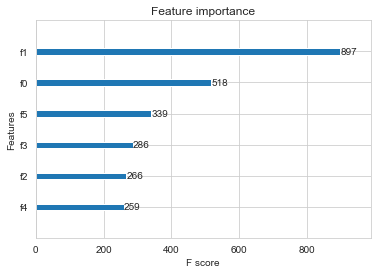

In [37]:
xgb.plot_importance(xg_clf, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 7]
plt.show()

In [38]:
feature_importances = xg_clf.feature_importances_

In [44]:
feature_importances

array([0.14932455, 0.02865257, 0.22947326, 0.37510052, 0.1446752 ,
       0.07277388], dtype=float32)

In [39]:
np.sort(feature_importances)[::-1]

array([0.37510052, 0.22947326, 0.14932455, 0.1446752 , 0.07277388,
       0.02865257], dtype=float32)

In [40]:
ind = np.argsort(feature_importances)

In [45]:
ind

array([1, 5, 4, 0, 2, 3])

In [46]:
feature_importances

array([0.14932455, 0.02865257, 0.22947326, 0.37510052, 0.1446752 ,
       0.07277388], dtype=float32)

In [47]:
num_cols.values

array(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'], dtype=object)